# Imports

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from fimpy.solver import create_fim_solver
from scipy.spatial import Delaunay

from eikonax import corefunctions, preprocessing, solver

sns.set_theme(style="ticks")

Import of Cupy failed. The GPU version of fimpy will be unavailable. Message: No module named 'cupy'


# Auxiliary functions

In [7]:
# Set up a simple square mesh
def generate_mesh(num_points):
    mesh_bounds_x = (0, 1)
    mesh_bounds_y = (0, 1)
    num_points_x = num_points
    num_points_y = num_points
    mesh_points_x = np.linspace(*mesh_bounds_x, num_points_x)
    mesh_points_y = np.linspace(*mesh_bounds_y, num_points_y)
    mesh_points = np.column_stack(
        (np.repeat(mesh_points_x, num_points_x), np.tile(mesh_points_y, num_points_y))
    )
    triangulation = Delaunay(mesh_points)
    vertices = triangulation.points
    simplices = triangulation.simplices
    return vertices, simplices


# Create a uniform tensor field array
def generate_uniform_tensor_field(num_simplices):
    tensor_field = np.repeat(np.identity(2)[np.newaxis, :, :], num_simplices, axis=0)
    return tensor_field


# Create a random tensor field array
def generate_random_tensor_field(num_simplices):
    rng = np.random.default_rng(seed=0)
    inv_speed_values = rng.uniform(0.1, 5, num_simplices)
    tensor_field = np.repeat(np.identity(2)[np.newaxis, :, :], num_simplices, axis=0)
    tensor_field = np.einsum("i,ijk->ijk", inv_speed_values, tensor_field)
    return tensor_field


# Create tensor field array with sink at (0.65, 0.65)
def generate_function_tensor_field(vertices, simplices):
    simplex_centers = np.mean(vertices[simplices], axis=1)
    inv_speed_values = 1 / (
        1
        + 10
        * np.exp(-50 * np.linalg.norm(simplex_centers - np.array([[0.65, 0.65]]), axis=-1) ** 2)
    )
    tensor_field = np.repeat(np.identity(2)[np.newaxis, :, :], simplices.shape[0], axis=0)
    tensor_field = np.einsum("i,ijk->ijk", inv_speed_values, tensor_field)
    return tensor_field

# Prepare tensor fields and Eikonax

In [8]:
# Set up mesh and tensor fields
num_points = 100
initial_sites = (np.array([0]), np.array([0]))
vertices, simplices = generate_mesh(num_points)
simplex_centers = np.mean(vertices[simplices], axis=1)
uniform_tensor_field = generate_uniform_tensor_field(simplices.shape[0])
random_tensor_field = generate_random_tensor_field(simplices.shape[0])
function_tensor_field = generate_function_tensor_field(vertices, simplices)

# Prepare Eikonax solver
eikonax_initial_sites = corefunctions.InitialSites(inds=jnp.array((0,)), values=jnp.array((0,)))
eikonax_adjacency_data = preprocessing.get_adjacent_vertex_data(simplices, vertices.shape[0])
eikonax_mesh_data = corefunctions.MeshData(vertices=vertices, adjacency_data=eikonax_adjacency_data)
eikonax_solver_data = solver.SolverData(
    tolerance=1e-8,
    max_num_iterations=1000,
    loop_type="jitted_while",
    max_value=1000,
    use_soft_update=False,
    softminmax_order=20,
    softminmax_cutoff=1.0,
    log_interval=1,
)

# Run Solvers

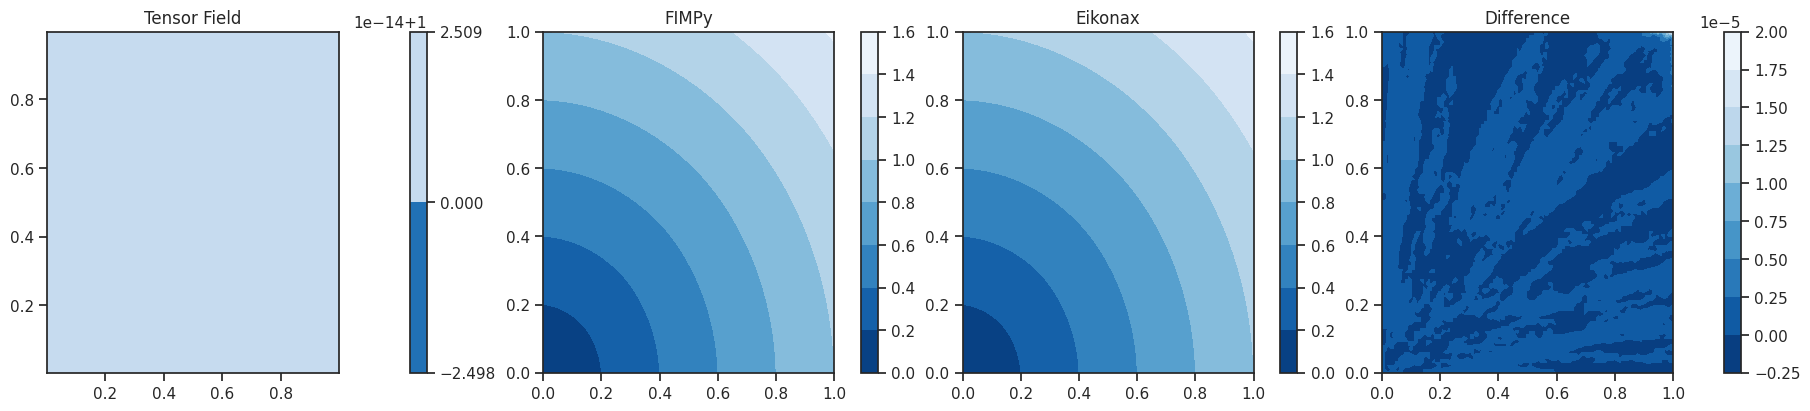

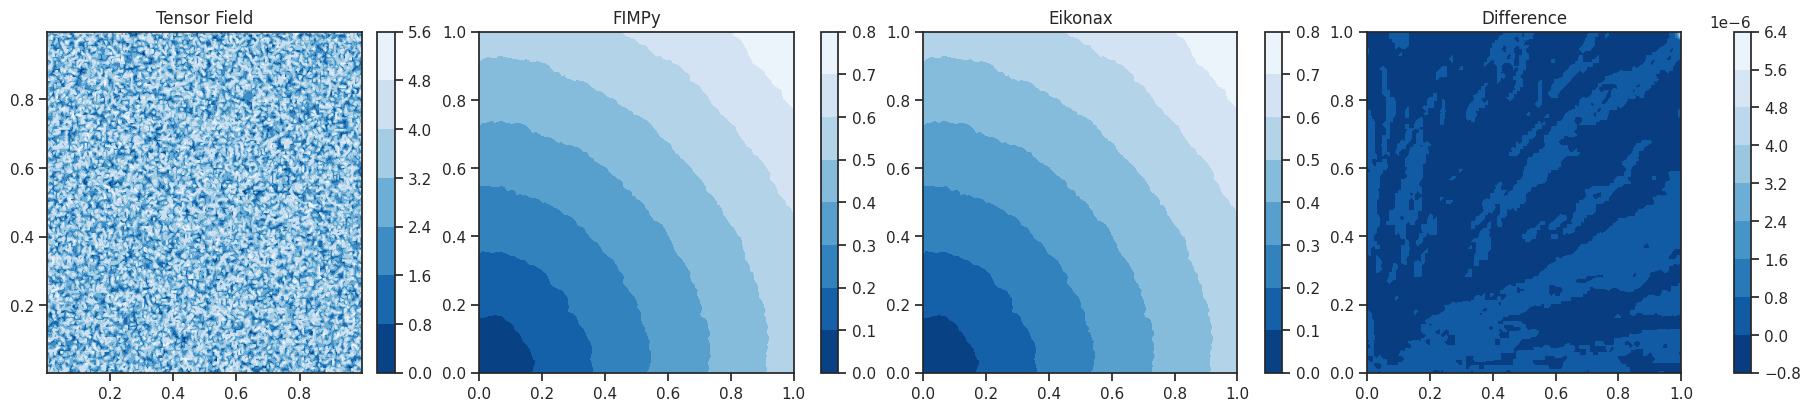

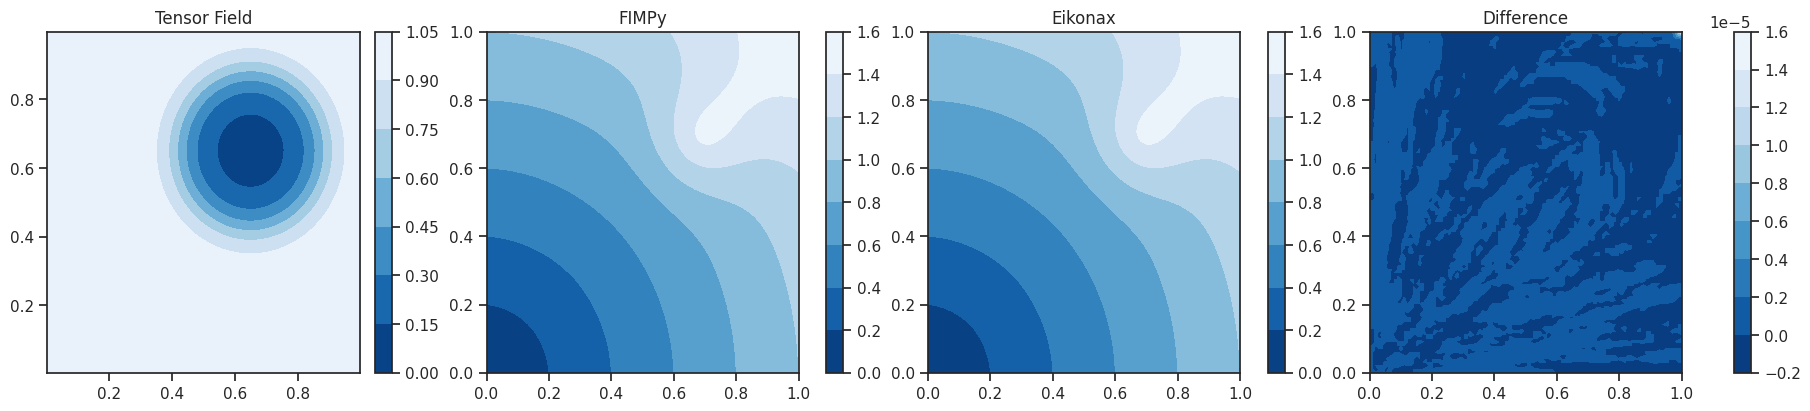

In [9]:
# Compare FIMPy and Eikonax solutions
for tensor_field in [uniform_tensor_field, random_tensor_field, function_tensor_field]:
    # Evaluate eikonal equation with FIMPy
    fimpython_solver = create_fim_solver(vertices, simplices, tensor_field, use_active_list=False)
    fimpython_solution = fimpython_solver.comp_fim(*initial_sites)

    # Evaluate eikonal equation with Eikonax
    eikonax_tensor_field = jnp.array(np.linalg.inv(tensor_field))
    eikonax_solver = solver.Solver(eikonax_mesh_data, eikonax_solver_data, eikonax_initial_sites)
    eikonax_solution = np.array(eikonax_solver.run(eikonax_tensor_field).values)
    solution_diff = fimpython_solution - eikonax_solution

    # Plot tensor field, solutions and difference
    plot_titles = ["FIMPy", "Eikonax", "Difference"]
    arrays_to_plot = [fimpython_solution, eikonax_solution, solution_diff]
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 4), layout="constrained")
    axs[0].set_title("Tensor Field")
    contour_plot = axs[0].tricontourf(
        simplex_centers[:, 0], simplex_centers[:, 1], tensor_field[:, 0, 0], cmap="Blues_r"
    )
    plt.colorbar(contour_plot)
    for ax, title, array in zip(axs[1:], plot_titles, arrays_to_plot, strict=True):
        ax.set_title(title)
        contour_plot = ax.tricontourf(vertices[:, 0], vertices[:, 1], array, cmap="Blues_r")
        plt.colorbar(contour_plot)